In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(
    root="C:/Users/516-29/Deep/chap13/data", train=True, transform=transform, download=True)

test_dataset = datasets.MNIST(
    root="C:/Users/516-29/Deep/chap13/data", train=False, transform=transform, download=True)

train_loader = DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=False)

test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [3]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

class Decoder(nn.Module):
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [4]:
encoder = Encoder(encoded_space_dim=4, fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=4, fc2_input_dim=128)
encoder.to(device)
decoder.to(device)

paramas_to_optimize = [
    {'params' : encoder.parameters()},
    {'params' : decoder.parameters()}
]

optim = torch.optim.Adam(paramas_to_optimize, lr = 0.002, weight_decay=1e-05)
loss_fn = torch.nn.MSELoss()

In [5]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer, noise_factor=0.3):
    encoder.train()
    decoder.train()
    train_loss = []
    for image_batch, _ in dataloader:
        image_noisy = add_noise(image_batch, noise_factor)
        image_noisy = image_noisy.to(device)
        encoded_data = encoder(image_noisy)
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data, image_noisy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

In [6]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn, noise_factor=0.3):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)
            encoded_data = encoder(image_batch)
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [7]:
def add_noise(inputs, noise_factor=0.3):
    noisy = inputs + torch.randn_like(inputs) * noise_factor
    noisy = torch.clip(noisy, 0., 1.)
    return noisy

In [8]:
from matplotlib import font_manager
font_fname = 'C:/Windows/Fonts/malgun.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()
plt.rcParams["font.family"] = font_family

In [9]:
def plot_ae_outputs(encoder, decoder, n=5, noise_factor=0.3):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
        ax = plt.subplot(3, n, i+1)
        img = test_dataset[i][0].unsqueeze(0)
        image_noisy = add_noise(img, noise_factor)
        image_noisy = image_noisy.to(device)

        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img = decoder(encoder(image_noisy))

        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('원래 이미지')
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('노이즈가 적용되어 손상된 이미지')

        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('재구성된 이미지')
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.7,
                        top=0.9,
                        wspace=0.3,
                        hspace=0.3)
    plt.show()

EPOCH 1/2

 EPOCH 1/2 	 train loss 0.067 	 val loss 0.045


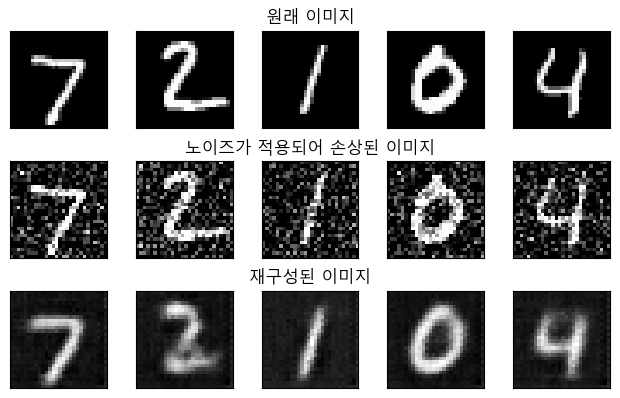

EPOCH 2/2

 EPOCH 2/2 	 train loss 0.054 	 val loss 0.043


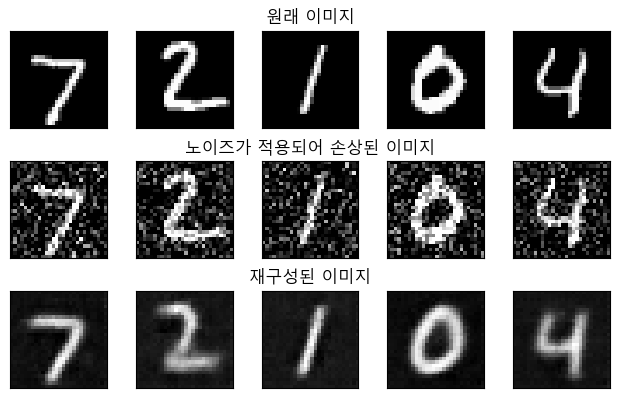

In [10]:
import numpy as np

num_epochs = 2 # 원래 30인데 2로 바꿈
history_da = {'train_loss':[],'val_loss':[]}
loss_fn = torch.nn.MSELoss()

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    train_loss=train_epoch(
        encoder=encoder,
        decoder=decoder,
        device=device,
        dataloader=train_loader,
        loss_fn=loss_fn,
        optimizer=optim, noise_factor=0.3)
    val_loss = test_epoch(
        encoder=encoder,
        decoder=decoder,
        device=device,
        dataloader=test_loader,
        loss_fn=loss_fn, noise_factor=0.3)
    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    plot_ae_outputs(encoder, decoder, noise_factor=0.3)